In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import Word2Vec
import numpy as np

In [ ]:
import os
import pandas as pd
import numpy as np

PATH = "/content/drive/MyDrive/data_peliculas"
train_file_path = os.path.join(PATH, "train_nltk_data.pkl")
test_file_path = os.path.join(PATH, "test_nltk_data.pkl")
kaggle_file_path = os.path.join(PATH, "kaggle_nltk_data.pkl")

if os.path.exists(train_file_path) and os.path.exists(test_file_path):
    nltk_train_df = pd.read_pickle(train_file_path)
    nltk_test_df = pd.read_pickle(test_file_path)
    nltk_kaggle_df = pd.read_pickle(kaggle_file_path)
    print("DataFrames cargados exitosamente.")
else:
    print(f"Uno o ambos archivos no existen en la ruta especificada:\n{train_file_path}\n{test_file_path}")

DataFrames cargados exitosamente.


In [ ]:
print(nltk_train_df.shape)
print(nltk_test_df.shape)
print(nltk_kaggle_df.shape)

(20000, 3)
(5000, 3)
(25000, 2)


In [ ]:
print(nltk_train_df.head())

                                                 message  \
773    It is nothing more than a weird coincidence th...   
260    THIS IS BY FAR MY MOST FAVOURITE MOVIE IN THE ...   
18026  I guess every time I see one of these old movi...   
19309  I thoroughly enjoyed this movie because there ...   
24851  My roommate got the No No Nanette soundtrack a...   

                                                     POS  label  
773    [(be, V), (nothing, N), (more, J), (weird, J),...      0  
260    [(THIS, N), (IS, V), (BY, N), (FAR, N), (MY, N...      1  
18026  [(guess, V), (time, N), (see, V), (old, J), (m...      1  
19309  [(thoroughly, R), (enjoy, V), (movie, N), (be,...      1  
24851  [(roommate, N), (get, V), (No, N), (No, N), (N...      0  


In [ ]:
print(nltk_train_df.head())

                                                 message  \
773    It is nothing more than a weird coincidence th...   
260    THIS IS BY FAR MY MOST FAVOURITE MOVIE IN THE ...   
18026  I guess every time I see one of these old movi...   
19309  I thoroughly enjoyed this movie because there ...   
24851  My roommate got the No No Nanette soundtrack a...   

                                                     POS  label  
773    [(be, V), (nothing, N), (more, J), (weird, J),...      0  
260    [(THIS, N), (IS, V), (BY, N), (FAR, N), (MY, N...      1  
18026  [(guess, V), (time, N), (see, V), (old, J), (m...      1  
19309  [(thoroughly, R), (enjoy, V), (movie, N), (be,...      1  
24851  [(roommate, N), (get, V), (No, N), (No, N), (N...      0  


In [ ]:
print(nltk_kaggle_df.head())

                                             message  \
0  Acclaimed Argentine horror director Emilio Vie...   
1  I do not know if it is fair for me to review t...   
2  The only good thing about Persepolis is the sh...   
3  I completely forgot that I would seen this wit...   
4  B Kennedy tried to make a sequel by exaggerati...   

                                                 POS  
0  [(Acclaimed, N), (Argentine, N), (horror, N), ...  
1  [(do, V), (not, R), (know, V), (be, V), (fair,...  
2  [(only, R), (good, J), (thing, N), (Persepolis...  
3  [(completely, R), (forget, V), (see, V), (coup...  
4  [(B, N), (Kennedy, N), (try, V), (make, V), (s...  


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torchvision.transforms import ToTensor
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:

max_words = 5000
max_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(nltk_train_df['message'].values)

X = tokenizer.texts_to_sequences(nltk_train_df['message'].values)
X = pad_sequences(X, maxlen=max_len)


encoder = LabelEncoder()
y = encoder.fit_transform(nltk_train_df['label'].values)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SentimentDataset(X_train_tensor, y_train_tensor)
val_dataset = SentimentDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, lstm_output):

        attention_weights = torch.tanh(self.attention(lstm_output))
        attention_weights = torch.softmax(attention_weights, dim=1)
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        return context_vector, attention_weights


class SentimentModelWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(SentimentModelWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True, bidirectional=True, dropout=0.5)
        self.attention = Attention(hidden_size * 2)  # multiplicamos por 2 porque la LSTM es bidireccional
        self.fc1 = nn.Linear(hidden_size * 2, 256)  # tamaño aumentado
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_size)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(256)

    def forward(self, x):
        x = self.embedding(x)
        lstm_output, (h_n, c_n) = self.lstm(x)
        context_vector, attention_weights = self.attention(lstm_output)
        x = self.relu(self.fc1(context_vector))
        x = self.dropout(x)
        x = self.batch_norm(x)  # normalización de batch
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x, attention_weights

vocab_size = max_words
embed_size = 128
hidden_size = 128
output_size = 2

model = SentimentModelWithAttention(vocab_size, embed_size, hidden_size, output_size)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
X_kaggle = tokenizer.texts_to_sequences(nltk_kaggle_df['message'].values)
X_kaggle = pad_sequences(X_kaggle, maxlen=max_len)

In [ ]:
X_kaggle_tensor = torch.tensor(X_kaggle, dtype=torch.long)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, confusion_matrix

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
best_f1 = 0
best_model_path = 'best_model.pth'

for epoch in range(num_epochs):
    total_loss = 0
    model.train()

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs, attention_weights = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

    # Validación
    model.eval()
    with torch.no_grad():
        val_preds = []
        val_labels = []
        for batch_X, batch_y in val_loader:
            outputs, _ = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.tolist())
            val_labels.extend(batch_y.tolist())

    # F1-score
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    print(f'Validation F1-Score: {val_f1}')

    # matriz de confusión
    conf_matrix = confusion_matrix(val_labels, val_preds)
    print('Confusion Matrix:')
    print(conf_matrix)


    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved best model with F1-Score: {val_f1}')

    model.train()

Epoch 1/10, Loss: 0.5471664729714394
Validation F1-Score: 0.8339144231830732
Confusion Matrix:
[[1517  501]
 [ 159 1823]]
Saved best model with F1-Score: 0.8339144231830732
Epoch 2/10, Loss: 0.3046883699595928
Validation F1-Score: 0.8623982094968774
Confusion Matrix:
[[1836  182]
 [ 367 1615]]
Saved best model with F1-Score: 0.8623982094968774
Epoch 3/10, Loss: 0.2276346757784486
Validation F1-Score: 0.8819225857152467
Confusion Matrix:
[[1721  297]
 [ 175 1807]]
Saved best model with F1-Score: 0.8819225857152467
Epoch 4/10, Loss: 0.16546263493970037
Validation F1-Score: 0.8957515833690173
Confusion Matrix:
[[1805  213]
 [ 204 1778]]
Saved best model with F1-Score: 0.8957515833690173
Epoch 5/10, Loss: 0.10849782702326774
Validation F1-Score: 0.8872522197968408
Confusion Matrix:
[[1782  236]
 [ 215 1767]]
Epoch 6/10, Loss: 0.06684657481405884
Validation F1-Score: 0.8899889148367894
Confusion Matrix:
[[1811  207]
 [ 233 1749]]
Epoch 7/10, Loss: 0.03608718044741545
Validation F1-Score: 0.

In [ ]:

model_load = SentimentModelWithAttention(vocab_size, embed_size, hidden_size, output_size)


model_load.load_state_dict(torch.load('best_model.pth'))


model_load.eval()

<ipython-input-19-79df54651042>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_load.load_state_dict(torch.load('best_model.pth'))


SentimentModelWithAttention(
  (embedding): Embedding(5000, 128)
  (lstm): LSTM(128, 128, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): Attention(
    (attention): Linear(in_features=256, out_features=1, bias=False)
  )
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

Confusion Matrix:
[[1805  213]
 [ 204 1778]]
Accuracy: 0.8958
Precision: 0.8930
Recall: 0.8971
F1-Score: 0.8950


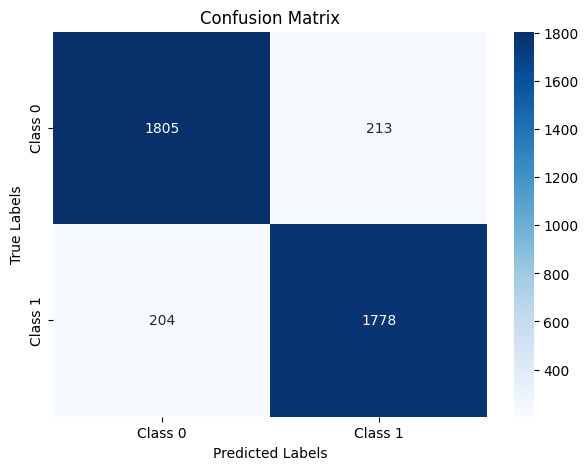

In [ ]:
val_preds = []
val_labels = []


with torch.no_grad():
    for batch_X, batch_y in val_loader:
        outputs, _ = model_load(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        val_preds.extend(predicted.tolist())
        val_labels.extend(batch_y.tolist())

conf_matrix = confusion_matrix(val_labels, val_preds)


accuracy = accuracy_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds)
recall = recall_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds)



print('Confusion Matrix:')
print(conf_matrix)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')



plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# kaggle_preds = []
# with torch.no_grad():
#     for i in range(len(X_kaggle_tensor)):
#         output, _ = model_load(X_kaggle_tensor[i].unsqueeze(0))  # Agregar una dimensión para el batch
#         _, predicted = torch.max(output.data, 1)
#         kaggle_preds.append(predicted.item())

# # 4. Guardar las predicciones en un archivo CSV
# kaggle_submission_df = pd.DataFrame({
#     'ids': nltk_kaggle_df.index,
#     'label': kaggle_preds
# })

# kaggle_submission_df.to_csv('kaggle_submission.csv', index=False)
# print("Archivo de predicciones 'kaggle_submission.csv' guardado exitosamente.")

Archivo de predicciones 'kaggle_submission.csv' guardado exitosamente.


In [ ]:
kaggle_preds = []
with torch.no_grad():
    for i in range(len(X_kaggle_tensor)):
        output, _ = model_load(X_kaggle_tensor[i].unsqueeze(0))  # Agregar una dimensión para el batch
        _, predicted = torch.max(output.data, 1)
        kaggle_preds.append(predicted.item())

# Convertir las etiquetas a "pos" y "neg"
kaggle_preds = ['pos' if label == 1 else 'neg' for label in kaggle_preds]


kaggle_submission_df = pd.DataFrame({
    'ids': nltk_kaggle_df.index,
    'label': kaggle_preds
})

kaggle_submission_df.to_csv('kaggle_submission.csv', index=False)
print("Archivo de predicciones 'kaggle_submission.csv' guardado exitosamente.")

Archivo de predicciones 'kaggle_submission.csv' guardado exitosamente.
